In [1]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase

import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler

import Control.Monad
import Data.List
import Data.Ord
import Control.Arrow (first)
import Data.Text (pack, Text)
import Numeric.Log
import Control.Arrow (second)

:l Plotting.hs

# Sampling

Before discussing inference, we should understand how to sample from models. This notebook explains how to do that.

We'll start with a very simple model, namely:

In [2]:
model :: MonadSample m => m Bool
model = bernoulli 0.7

To take a sample, do:

In [3]:
sampleIO model

True

Or with a fixed seed:

In [4]:
sampleIOfixed model

True

To take multiple samples, you could rerun `sampleIO` many times, but it's somewhat more in the probabilistic programming spirit to instead define a distribution over multiple draws from `model` and then just sample once, as follows:

In [5]:
multipleDraws :: MonadSample m => m [Bool]
multipleDraws = replicateM 10 model

draws <- sampleIO multipleDraws

draws

[True,False,False,True,True,False,False,False,True,False]

We can write a function to convert a list of samples to an empirical distribution, like so:

In [6]:
emp = toEmpirical draws :: [(Bool, Double)]

emp



[(False,0.6),(True,0.4)]

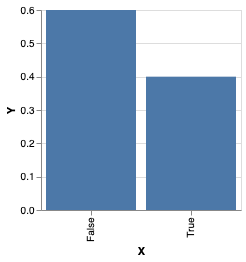

In [9]:
plotVega $ first (pack . show) <$> emp

In fact, we could lean even further into the spirit of probabilistic programming, and transform `model` into a distribution over plots, and sample from that:

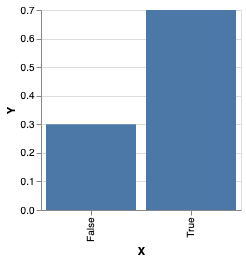

In [10]:
distributionOverPlots :: MonadSample m => m VegaLiteLab -- the type of plots
distributionOverPlots = 
    plotVega . fmap (first (pack . show)) . toEmpirical 
    <$> replicateM 10 model

sampleIO distributionOverPlots


Now for a continuous distribution, consider

In [11]:
model2 :: MonadSample m => m Double
model2 = normal 0 1

Sampling is no different to before:

In [12]:
sampleIO model2

0.6236329933678874

And as before, to obtain multiple draws:

In [13]:
multipleDraws2 :: MonadSample m => m [Double]
multipleDraws2 = replicateM 10 model2

draws2 <- sampleIO multipleDraws2

draws2

[0.9701184520875676,-2.8847267885226364e-2,0.9464777595839039,0.41910059667636623,1.1125708743347604,-0.44056161644123953,1.1065772705787429,0.5290610959860976,0.5744518578774057,9.408265732831282e-2]

We'd like to view a histogram of samples, which in the limit of many samples should tend to the PDF of a normal distribution. Again, we could apply a histogram to the list of samples, but it's nicer to apply a `histogram` function to `multipleDraws`, to define a distribution over histograms from which we'll sample.

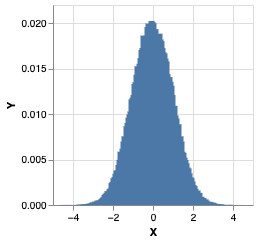

In [15]:
sampleIO $ 
    plotVega . toEmpirical . toBins 0.05 
    <$> replicateM 100000 model2



In [16]:
model3 = do
    p <- bernoulli 0.7
    if p then normal 0 1 else normal 3 1

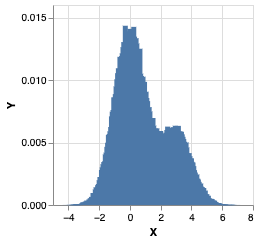

In [17]:
sampleIO $ 
    plotVega . toEmpirical . toBins 0.05 
    <$> replicateM 100000 model3


# Weighted Sampling

For models with factor statements, we cannot just sample. For example, consider:

In [18]:
model4 = do
    p <- bernoulli 0.7
    out <- if p then normal 0 1 else normal 3 1
    condition (out > 0)
    return out


We could ignore the `condition` statement using `prior`, as in:

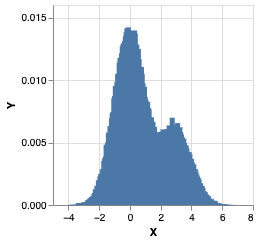

In [19]:
sampleIO . prior $ 
    plotVega . toEmpirical . toBins 0.05 
    <$> replicateM 100000 model4


But obviously, we'd like to take samples from the posterior. We can do so as follows:

In [ ]:
draws4 <- sampleIO $ replicateM 10 $ runWeighted model4
draws4

[(1.7633420445268524,1.0),(2.78493875227416,1.0),(1.0459312326533174,1.0),(2.4879279652564077,1.0),(1.3958158026394436,1.0),(-1.3272681754686486,0.0),(-0.4399149407281314,0.0),(3.5174010113972534,1.0),(-0.6471909156430901,0.0),(-0.3269929580826737,0.0)]

Here, we use `runWeighted` to convert `model4` into a distribution over pairs of numbers and their weights. We then sample from that. To view 

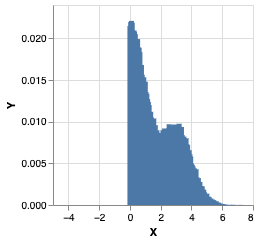

In [24]:
sampleIO $ 
    plotVega . fmap (second (ln . exp)) . toEmpiricalWeighted . toBinsWeighted 0.05 
    <$> replicateM 100000 (runWeighted model4)

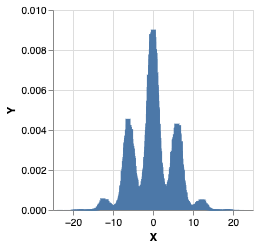

In [26]:
model5 :: MonadInfer m => m Double
model5 = do
    x <- normal 0 5
    (factor . Exp) (cos x)
    return x

sampleIO $ 
    plotVega . fmap (second (ln . exp)) . toEmpiricalWeighted . toBinsWeighted 0.05 
    <$> replicateM 100000 (runWeighted model5)